https://qiita.com/T-STAR/items/728b5c279bcfb6a6381f

#GetData

In [1]:
#signate.jsonをGoogle Drive からひっぱってくるやつ
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
 
auth.authenticate_user()
 
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])
 
filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
 
request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 44, in autodetect
    from . import file_cache
  File "/usr/local/lib/python3.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    "file_cach

IndexError: ignored

In [ ]:
!pip install -q signate

     |████████████████████████████████| 153kB 8.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!mkdir input
!signate download --competition-id=108 --path='input'
#--competition-id=269 --path='move/'

label_master.tsv

train_master.tsv

sample_submit.csv

test.zip

train.zip


Download completed.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
path="/content/drive/MyDrive/signate_practice_chuzo/input"
zip_files=os.listdir(path)
zip_files

['sample_submission.csv',
 'test.zip',
 'train.zip',
 'train.csv',
 'label_master.tsv',
 '__MACOSX',
 'test',
 '.ipynb_checkpoints',
 'train']

In [6]:
import zipfile
for i in zip_files:
    if ".zip" in i:
        with zipfile.ZipFile("/content/drive/MyDrive/signate_practice_chuzo/input/"+i) as existing_zip:
            existing_zip.extractall("/content/drive/MyDrive/signate_practice_chuzo/input/")
    else:
        continue

In [8]:
import  pandas as pd

In [9]:
# 読み込むデータが格納されたディレクトリのパス，必要に応じて変更の必要あり
path = "/content/drive/MyDrive/signate_practice_chuzo/input/"

_train_images_path = os.path.join(path,'train')
_test_images_path = os.path.join(path,'test')
_train_master_path = os.path.join(path,'train.csv')
_label_master_path = os.path.join(path,'label_master.tsv')
train_master = pd.read_csv(_train_master_path)
label_master = pd.read_csv(_label_master_path, sep='\t')
sub=pd.read_csv('/content/drive/MyDrive/signate_practice_chuzo/input/sample_submission.csv', header=None)
 
#img_shape = (224,224)
n_class=label_master.label_id.nunique()
# train_X = np.zeros((50000,32,32,3))
# train_Y = np.zeros((50000)).astype('int64')

In [10]:
from PIL import Image
import numpy as np

In [11]:
train_master

,id,target
0,cast_def_0_335.jpeg,0
1,cast_def_0_323.jpeg,0
2,cast_def_0_61.jpeg,0
3,cast_def_0_163.jpeg,0
4,cast_def_0_175.jpeg,0
...,...,...
245,cast_ok_0_346.jpeg,1
246,cast_ok_0_307.jpeg,1
247,cast_ok_0_242.jpeg,1
248,cast_ok_0_184.jpeg,1


In [12]:
train_X=[]
train_Y=[]
 
for index, row in train_master.iterrows():
    for i in range(n_class):
        if i == row['target']:
            img = Image.open(os.path.join(_train_images_path , row['id'])).convert("RGB")
            train_X.append(np.array(img))#(np.array(img.resize((96,96),Image.LANCZOS)) / 255)#
            train_Y.append(i)
        else:
            pass
train_X=np.array(train_X)
train_Y=np.array(train_Y)
print("train image load done")
print(train_X.shape)

train image load done
(250, 300, 300, 3)


#Code

In [13]:
!pip install --upgrade tensorflow-addons
 
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import time
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
 
print(f'tf_ver={tf.__version__} / tfa_ver={tfa.__version__}')
 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, random_state=0, test_size=0.2, stratify=train_Y)
train_data = (x_train, to_categorical(y_train))
validation_data = (x_test, to_categorical(y_test))
 
MODEL_NAME = 'ViT-B_16'
# MODEL_NAME = 'ViT-L_16'
!wget https://storage.googleapis.com/vit_models/imagenet21k/{MODEL_NAME}.npz
vit_weights = np.load(MODEL_NAME+'.npz')

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
tf_ver=2.6.0 / tfa_ver=0.14.0
--2021-09-04 02:32:26--  https://storage.googleapis.com/vit_models/imagenet21k/ViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.197.128, 64.233.191.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412815506 (394M) [application/octet-stream]
Saving to: ‘ViT-B_16.npz’

ViT-B_16.npz        100%[===================>] 393.69M  87.8MB/s    in 4.5s    

2021-09-04 02:32:31 (87.8 MB/s) - ‘ViT-B_16.npz’ saved [412815506/412815506]



In [14]:
len(validation_data[1][0])

2

In [15]:
del train_X, train_Y

In [16]:
@tf.function
def image_augmentation(images,
                       width_shift_range=0., height_shift_range=0.,
                       rotation_range = 0.0, 
                       horizontal_flip=True,
                       vertical_flip=True,
                       cval=0.0, cutout_size=None, cutout_num=1, 
                       ):
 
    img_shape = images.shape[-3:]
    img_width = img_shape[1]
    img_height = img_shape[0]
    interpolation  = 'BILINEAR' if rotation_range!=0.0 else 'NEAREST'
 
    def transform(image):
        mirror_x = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.dtypes.int32)*2-1, tf.float32) if horizontal_flip else 1.0
        mirror_y = tf.cast(tf.random.uniform(shape=[], minval=0, maxval=2, dtype=tf.dtypes.int32)*2-1, tf.float32) if vertical_flip else 1.0
        width_shift = tf.random.uniform(shape=[], minval=-width_shift_range, maxval=width_shift_range)*img_width
        height_shift = tf.random.uniform(shape=[], minval=-height_shift_range, maxval=height_shift_range)*img_width
        zoom_x = 1.0
        zoom_y = 1.0
        center = img_width/2
 
        angle = tf.random.uniform(shape=[], minval=-rotation_range, maxval=rotation_range)*3.141519/180
        sinval = tf.sin(angle)
        cosval = tf.cos(angle)
        center_mat = [1.0, 0.0, center, 0.0, 1.0, center, 0.0, 0.0]
        rotate_mat = [cosval, -sinval, 0.0, sinval, cosval, 0.0, 0.0, 0.0]
        zoom_mat = [zoom_x*mirror_x, 0.0, 0.0, 0.0, zoom_y*mirror_y, 0.0, 0.0, 0.0]
        center_mat_inv = [1.0, 0.0, width_shift-center, 0.0, 1.0, height_shift-center, 0.0, 0.0]
        matrix = [center_mat, rotate_mat, zoom_mat, center_mat_inv]
        composed_matrix = tfa.image.transform_ops.compose_transforms(matrix)
        (h, w, c) = (img_shape[0], img_shape[1], img_shape[2])
        images = tf.reshape( image, [1, h, w, c] )
        images = tf.raw_ops.ImageProjectiveTransformV2(
            images=images, transforms=composed_matrix, output_shape=[h, w], 
            fill_mode='REFLECT', interpolation=interpolation)
        image = tf.reshape( images, [h, w, c] )
        return image
 
    def cutout(image, cval=0, cnum = 6, csize = 0.25):
        DIM = image.shape[0]
        for k in range( cnum ):
            # CHOOSE RANDOM LOCATION
            x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            # COMPUTE SQUARE 
            WIDTH = tf.cast( csize*DIM,tf.int32)
            ya = tf.math.maximum(0,y-WIDTH//2)
            yb = tf.math.minimum(DIM,y+WIDTH//2)
            xa = tf.math.maximum(0,x-WIDTH//2)
            xb = tf.math.minimum(DIM,x+WIDTH//2)
            # DROPOUT IMAGE
            one = image[ya:yb,0:xa,:]
            two = tf.fill([yb-ya,xb-xa,3], tf.cast(cval, image.dtype) ) 
            three = image[ya:yb,xb:DIM,:]
            middle = tf.concat([one,two,three],axis=1)
            image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)
 
        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
        image = tf.reshape(image,[DIM,DIM,3])
        return image
    
    def random_color(image, prob):
        img_tmp = tf.image.random_saturation(image, 0.5, 1.5)
        img_tmp = tf.image.random_contrast(img_tmp, 0.8, 1.5)
        img_tmp = tf.clip_by_value(img_tmp, 0, 255)
        p = tf.random.uniform([],0.0,1.0)
        return tf.where(p<prob, tf.cast(img_tmp, image.dtype) , image)
 
 
    images = tf.map_fn(lambda image: transform(image), images)
 
    # images = tf.map_fn( lambda image: random_color(image, prob=0.5), images)
 
    if cutout_size!=None and cutout_num!=0:
        images = tf.map_fn(lambda image: cutout(image,cval=cval, csize=cutout_size, cnum=cutout_num), images)
    return images
 
def make_dataset(train_data, validation_data, batch_size, cutout_size=0.25, cutout_num=1):
    (x_train, label_train) = train_data
    (x_test, label_test) = validation_data
 
    train_len = len(x_train)
    test_len = len(x_test)
 
    ds_train = tf.data.Dataset.from_tensor_slices(train_data)
    ds_train = ds_train.shuffle(train_len).batch(batch_size)
    ds_validation = tf.data.Dataset.from_tensor_slices(validation_data)
    ds_validation = ds_validation.batch(batch_size)
 
    def data_augmentation(images, labels, aug):
        if aug:
            images = image_augmentation(images, 
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        horizontal_flip=True,
                                        cval=127.0,
                                        cutout_size=cutout_size, cutout_num=cutout_num,
                                        )
 
        images = tf.image.resize(images,(224,224))
        return images, labels
 
    ds_train = ds_train.map(lambda image, label: data_augmentation(image, label,True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)
 
    ds_validation = ds_validation.map(lambda image, label: data_augmentation(image, label,False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)
    return ds_train, ds_validation
 
def showHistory(history):
 
    # Setting Parameters
    acc = history['acc']
    val_acc = history['val_acc']
    max_acc = max(val_acc)
 
    loss = history['loss']
    val_loss = history['val_loss']
 
    epochs = range(len(acc))
 
    plt.figure(figsize=(16,6))
 
    # Accracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'r', label='Training')
    plt.plot(epochs, val_acc, 'b', label='Validation')
    plt.title('Accuracy')
    plt.grid()
    plt.legend()
 
    # Loss 
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'r', label='Training')
    plt.plot(epochs, val_loss, 'b', label='Validation')
    plt.title('Loss')
    if max(max(loss),max(val_loss))>10.0:
        plt.ylim(0.0,10.0)
    plt.grid()
    plt.legend()
    plt.show()
 
def train(model, optimizer, lr_scheduler, epochs, ds_train, ds_validation, label_smoothing=0.0):
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    model.compile(optimizer=optimizer,
                  loss=loss, metrics=[acc])
    history = model.fit(ds_train, epochs=epochs,
                        validation_data=ds_validation, callbacks=[lr_scheduler])
    showHistory(history.history)

In [17]:
# https://github.com/google-research/vision_transformer/blob/master/vit_jax/models.py
# https://github.com/jeonsworld/ViT-pytorch
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import  Dense, Dropout, Add, Concatenate, Reshape, Permute, Activation, Flatten, Conv2D, LayerNormalization
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        self.num_patches = num_patches
        self.d_model = d_model
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.pos_emb = self.add_weight("pos_emb", 
                                       shape=(1, self.num_patches + 1, self.d_model),
                                       initializer=tf.initializers.RandomNormal(stddev=0.02))
        self.class_emb = self.add_weight("class_emb", 
                                         shape=(1, 1, self.d_model),
                                         initializer=tf.initializers.Zeros())
        super().build(input_shape)
    def call(self,x):
        batch_size = tf.shape(x)[0]
        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb
        return x
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+1, input_shape[2], input_shape[3])
 
 
def vit(
    image_size = 224,
    patch_size = 16,
    channels = 3,
    d_model = 768,
    num_classes =21843,
    mlp_dim = 3072,
    num_layers = 12,
    num_heads = 12,
    dropout = 0.1,
    attention_dropout = 0.0):
 
    dense_kwargs = {
        'kernel_initializer':'glorot_uniform',
        'bias_initializer': tf.keras.initializers.RandomNormal(stddev=1e-6)
        }
    lnorm_kwargs = {'epsilon':1e-6}
 
    def MultiHead_SelfAttention(inputs, d_model, num_heads, dropout,prefix):
        projection_dim = d_model // num_heads
 
        query = Dense(d_model, name = prefix+"_Dense_query", **dense_kwargs)(inputs)
        key   = Dense(d_model, name = prefix+"_Dense_key"  , **dense_kwargs)(inputs)
        value = Dense(d_model, name = prefix+"_Dense_value", **dense_kwargs)(inputs)
        query = Reshape((-1, num_heads, projection_dim),name = prefix+"_Reshape_query")(query)
        key   = Reshape((-1, num_heads, projection_dim),name = prefix+"_Reshape_key"  )(key)
        value = Reshape((-1, num_heads, projection_dim),name = prefix+"_Reshape_value")(value)
 
        query = Permute((2, 1, 3), name = prefix+"_Permute_query")(query)
        key   = Permute((2, 1, 3), name = prefix+"_Permute_key")(key)
        value = Permute((2, 1, 3), name = prefix+"_Permute_value")(value)
 
        score = tf.matmul(query, key, transpose_b=True)
        score = score/K.sqrt(K.cast(projection_dim, 'float32'))
        attention_probs = Activation("softmax", name = prefix+"_Softmax_projection")(score) 
        if dropout != 0.0:
            attention_probs = Dropout(dropout, name=prefix+"_Dropout_projection")(attention_probs)
 
        attention = tf.matmul(attention_probs, value)
        attention = Permute((2, 1, 3), name = prefix+"_Permute_attention")(attention)
        attention = Reshape( (-1, d_model), name = prefix+"_Reshape_attention")(attention)
        output = Dense(d_model, name = prefix+"_Dense_out", **dense_kwargs)(attention)
        if dropout != 0.0:
            output = Dropout(dropout, name=prefix+"_Dropout_out")(output)
 
        return output
 
    x = inputs = tf.keras.layers.Input(shape=(image_size, image_size, channels), name="Input")
    
    num_patches = (image_size // patch_size) ** 2
    patch_dim = channels * patch_size ** 2
    x = Conv2D(d_model,patch_size,patch_size, padding='valid', name='Embedding_Conv2D')(x)
    x = Reshape((num_patches,d_model), name='Embedding_Reshape')(x)
    x = PatchEmbedding(num_patches,d_model, name="PatchEmbedding")(x)
 
    if dropout != 0.0:
       x = Dropout(dropout, name='Embedding_Dropout')(x)
 
    # Encoder
    for i in range(num_layers):
        prefix = f'Encoder_{i}'
        # Attention block.
        shortcut = x
        x = LayerNormalization(name = prefix+"_Attention_LayerNorm")(x)
        x = MultiHead_SelfAttention(x, d_model, num_heads, attention_dropout, prefix=prefix+"_MHSA" )
        x = Add(name=prefix+"_Attention_Add")([x,shortcut])
        # MLP block.
        shortcut = x
        x = LayerNormalization(name=prefix+"_MLP_LayerNorm",**lnorm_kwargs)(x)
        x = Dense(mlp_dim, name=prefix+"_MLP_Dense_0",**dense_kwargs)(x)
        x = Activation(tf.nn.gelu, name=prefix+"_MLP_GeLU")(x)
        if dropout != 0.0:
            x = Dropout(dropout, name=prefix+"_MLP_Dropout")(x)
        x = Dense(d_model, name=prefix+"_MLP_Dense_1", **dense_kwargs)(x)
        if dropout != 0.0:
            x = Dropout(dropout, name=prefix+"_MLP_Dropout_hidden")(x)
        x = Add(name=prefix+"_MLP_Add")([x,shortcut])
 
    x = LayerNormalization(name="Encoder_Norm", **lnorm_kwargs)(x)
    x = Dense(num_classes, kernel_initializer=tf.keras.initializers.Zeros() , name="Head_Dense")(x[:, 0])
    return tf.keras.Model(inputs,x) 
 
import re
import numpy as np
def load_vit_weights(model, weights, skip_head=False):
    for layer in model.layers:
        if len(layer.get_weights()) != 0:
            if layer.name == 'Embedding_Conv2D':
                layer_weights = [weights['embedding/kernel'],weights['embedding/bias']]
                layer.set_weights(layer_weights)
            elif layer.name == 'PatchEmbedding':
                layer_weights = [weights['Transformer/posembed_input/pos_embedding'],weights['cls']]
                layer.set_weights(layer_weights)
            elif layer.name == 'Head_Dense':
                if not skip_head:
                    layer_weights = [weights['head/kernel'],weights['head/bias']]
                    layer.set_weights(layer_weights)
                else:
                    print('skip',layer.name)
            elif layer.name == 'Encoder_Norm':
                layer_weights = [weights['Transformer/encoder_norm/scale'],weights['Transformer/encoder_norm/bias']]
                layer.set_weights(layer_weights)
            else:
                pattern = 'Encoder_(\d+)_MHSA_Dense_(.*)'
                result = re.match(pattern, layer.name)
                if result:
                    fname = f'Transformer/encoderblock_{result.group(1)}/MultiHeadDotProductAttention_1/{result.group(2)}/'
                    layer_weights = [weights[fname+'kernel'],weights[fname+'bias']]
                    for i,w in enumerate(layer.get_weights()):
                        layer_weights[i] = layer_weights[i].reshape(w.shape)
                    layer.set_weights(layer_weights)
                    continue
                pattern = 'Encoder_(\d+)_MLP_Dense_(\d+)'
                result = re.match(pattern, layer.name)
                if result:
                    fname = f'Transformer/encoderblock_{result.group(1)}/MlpBlock_3/Dense_{result.group(2)}/'
                    layer_weights = [weights[fname+'kernel'],weights[fname+'bias']]
                    for i,w in enumerate(layer.get_weights()):
                        layer_weights[i] = layer_weights[i].reshape(w.shape)
                    layer.set_weights(layer_weights)
                    continue
                pattern = 'Encoder_(\d+)_Attention_LayerNorm'
                result = re.match(pattern, layer.name)
                if result:
                    fname = f'Transformer/encoderblock_{result.group(1)}/LayerNorm_0/'
                    layer_weights = [weights[fname+'scale'],weights[fname+'bias']]
                    layer.set_weights(layer_weights)
                    continue
                pattern = 'Encoder_(\d+)_MLP_LayerNorm'
                result = re.match(pattern, layer.name)
                if result:
                    fname = f'Transformer/encoderblock_{result.group(1)}/LayerNorm_2/'
                    layer_weights = [weights[fname+'scale'],weights[fname+'bias']]
                    layer.set_weights(layer_weights)
                    continue
 
                for w in layer.get_weights():
                    print('!!!',layer.name, w.shape)

In [18]:
def build_model_for_cifar10(weights):
    if MODEL_NAME == 'ViT-B_16':
        vit_kwargs = {
            'patch_size' : 16,
            'd_model' : 768,
            'mlp_dim' : 3072,
            'num_layers' : 12,
            'num_heads' : 12,
        }
    elif MODEL_NAME == 'ViT-L_16':
        vit_kwargs = {
            'patch_size' : 16,
            'd_model' : 1024,
            'mlp_dim' : 4096,
            'num_layers' : 24,
            'num_heads' : 16,
        }
    elif MODEL_NAME == 'ViT-H_14':
        vit_kwargs = {
            'patch_size' : 14,
            'd_model' : 1280,
            'mlp_dim' : 5120,
            'num_layers' : 32,
            'num_heads' : 16,
        }
    vit_model = vit(num_classes=n_class, **vit_kwargs)
    if weights != None:
        load_vit_weights(vit_model, weights, skip_head=True)
    x = inputs = tf.keras.layers.Input(shape=(224,224, 3), name="Input")
    x = (x/127.5)-1.0 # normalize
    x = vit_model(x)
    x = tf.keras.layers.Activation('softmax')(x)
    #x = tf.keras.layers.Activation('sigmoid')(x)
    model = tf.keras.Model(inputs,x) 
    print('params', model.count_params())
    return model
 
def train_vit():
    BATCH_SIZE = 32
    EPOCHS = 150
    warmup_epochs = 3
    cooldown_epochs = 12
 
    steps_per_epoch = 250 // BATCH_SIZE
 
    label_smoothing = 0.1
    cutout_size=0.5
    cutout_num=1
 
    max_lr = 4e-2
    min_lr = max_lr/10
    optimizer = tf.keras.optimizers.SGD(max_lr, momentum=0.9)
    
    # max_lr=1e-5
    # min_lr=max_lr/10
    # optimizer = tf.keras.optimizers.Adam(max_lr)
 
    def scheduler(epoch, lr):
        flat_epochs = EPOCHS - warmup_epochs - cooldown_epochs
        if epoch < warmup_epochs:
            return min_lr + (max_lr-min_lr)*epoch/warmup_epochs
        elif epoch < warmup_epochs+flat_epochs:
            return max_lr
        else:
            epoch = epoch - (warmup_epochs+flat_epochs) + 1
            return min_lr + 0.5*(max_lr-min_lr)*(1.0+np.cos(epoch/cooldown_epochs*np.pi))
 
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
 
 
    model = build_model_for_cifar10(vit_weights)
    ds_train, ds_validation = make_dataset(train_data, validation_data, BATCH_SIZE, cutout_size=cutout_size, cutout_num=cutout_num)
 
    start_time = time.time()
 
    train(model,  optimizer, lr_scheduler, EPOCHS, ds_train, ds_validation, label_smoothing)
 
    print('Time;', time.time()-start_time)
    return model

In [19]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.16.53.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.16.53.218:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


skip Head_Dense
params 85800194
Epoch 1/150
7/7 [==============================] - 122s 10s/step - loss: 0.6891 - acc: 0.6000 - val_loss: 0.6695 - val_acc: 0.6000
Epoch 2/150
7/7 [==============================] - 2s 281ms/step - loss: 0.6704 - acc: 0.6000 - val_loss: 0.6359 - val_acc: 0.8400
Epoch 3/150
7/7 [==============================] - 2s 284ms/step - loss: 0.6115 - acc: 0.6650 - val_loss: 0.4908 - val_acc: 0.7200
Epoch 4/150
7/7 [==============================] - 2s 288ms/step - loss: 0.4137 - acc: 0.8600 - val_loss: 0.3212 - val_acc: 0.9200
Epoch 5/150
7/7 [==============================] - 2s 277ms/step - loss: 0.7077 - acc: 0.7450 - val_loss: 0.8358 - val_acc: 0.4000
Epoch 6/150
7/7 [==============================] - 2s 279ms/step - loss: 0.6730 - acc: 0.6000 - val_loss: 0.8971 - val_acc: 0.6000
Epoch 7/150
7/7 [==============================] - 2s 279ms/step - loss: 0.7124 - acc: 0.5650 - val_loss: 0.5772 - val_acc: 0.8600
Epoch 8/150
7/7 [==============================] - 

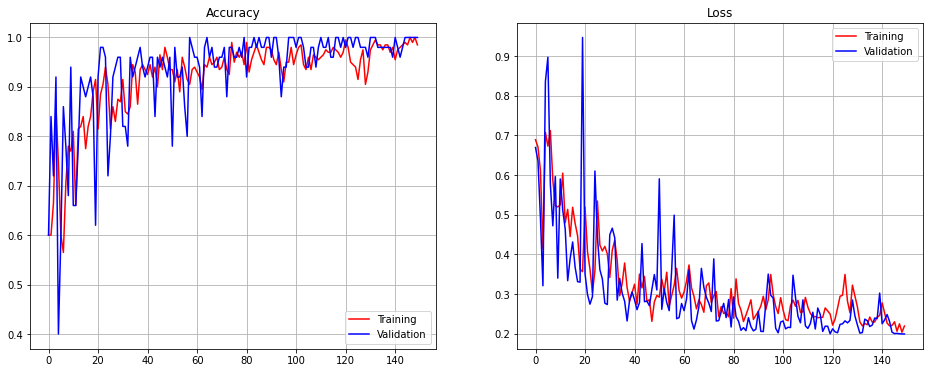

Time; 509.7979700565338


In [20]:
with strategy.scope():
    model=train_vit()

#Submit

In [21]:
test=pd.read_csv('/content/drive/MyDrive/signate_practice_chuzo/input/sample_submission.csv', header=None)
test.head()

,0,1
0,19871.jpeg,0
1,29934.jpeg,0
2,39826.jpeg,0
3,49888.jpeg,0
4,59918.jpeg,0


In [22]:
test_X=[] 
for index, row in test.iterrows():
    img = Image.open(os.path.join(_test_images_path , row[0])).convert("RGB")
    img_resize = img.resize((224, 224))
    test_X.append(np.array(img_resize))#.resize((224,224)))#,Image.LANCZOS)))# / 255)
print("test image load done")
#test_X=test_X.resize(224,224)
test_X=np.array(test_X)
print(test_X.shape)

test image load done
(100, 224, 224, 3)


In [23]:
#model.save('model_efnet_sch.h5')
test_preds = model.predict(test_X)

In [24]:
test_preds.shape

(100, 2)

In [25]:

preds = np.argmax(test_preds, 1)
preds

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0])

In [26]:
pred_df=pd.DataFrame(data=preds)
pred_df.head()

,0
0,1
1,1
2,1
3,0
4,1


In [27]:
test[1]=pred_df
test

,0,1
0,19871.jpeg,1
1,29934.jpeg,1
2,39826.jpeg,1
3,49888.jpeg,0
4,59918.jpeg,1
...,...,...
95,969983.jpeg,0
96,979891.jpeg,0
97,989921.jpeg,1
98,999921.jpeg,0


In [29]:
test.to_csv('/content/drive/MyDrive/signate_practice_chuzo/sub_vit_tpu_chuzo.csv', header=None, index=False)

In [ ]:
pd.read_csv('sub_vit_tpu2.csv', header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,test_00000.png,0.009689,0.005680,0.005962,0.006193,0.005917,0.010733,0.007104,0.005623,0.006315,0.614906,0.258867,0.006439,0.006826,0.003714,0.005997,0.007800,0.005365,0.006673,0.014747,0.005449
1,test_00001.png,0.005568,0.011249,0.004895,0.009053,0.009809,0.010192,0.010112,0.009713,0.008876,0.039102,0.602406,0.013679,0.005679,0.009734,0.041759,0.007707,0.017115,0.143049,0.029764,0.010536
2,test_00002.png,0.882534,0.004176,0.004944,0.004889,0.005360,0.007789,0.006355,0.004914,0.008474,0.005402,0.007100,0.006362,0.002875,0.004116,0.004807,0.017841,0.003731,0.006266,0.007411,0.004651
3,test_00003.png,0.007458,0.003538,0.003502,0.005076,0.912952,0.004400,0.005589,0.003113,0.003217,0.004920,0.005346,0.005805,0.004409,0.004524,0.005911,0.002458,0.004285,0.004428,0.005284,0.003785
4,test_00004.png,0.005425,0.005902,0.004709,0.005995,0.005450,0.005800,0.007490,0.006648,0.004242,0.003001,0.896053,0.007477,0.005842,0.004436,0.005369,0.006850,0.005384,0.005424,0.004464,0.004040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,test_09995.png,0.007139,0.005881,0.009521,0.009941,0.832538,0.009752,0.007492,0.010650,0.010416,0.008835,0.011343,0.005312,0.005456,0.008991,0.014727,0.014764,0.005231,0.004399,0.008991,0.008623
9996,test_09996.png,0.005793,0.010475,0.004357,0.006877,0.009120,0.008198,0.007736,0.860375,0.007091,0.008776,0.008543,0.007663,0.006003,0.004040,0.008056,0.006119,0.009086,0.008637,0.006709,0.006346
9997,test_09997.png,0.003437,0.003393,0.004858,0.005388,0.916765,0.004493,0.004236,0.004204,0.003358,0.004012,0.006861,0.003621,0.004872,0.004203,0.004641,0.004192,0.004328,0.004725,0.003944,0.004470
9998,test_09998.png,0.006977,0.008358,0.007841,0.008732,0.005829,0.008223,0.009074,0.010546,0.841155,0.009488,0.008883,0.004954,0.006151,0.007112,0.010307,0.014627,0.005669,0.008799,0.008606,0.008669


In [ ]:
#!signate submit -c 108 sub_vit_tpu2.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.
